# Adult RSV Cases/Admissions/Deaths in Denmark

In [5]:
source("common.R")

age_groups <- c("15-44 years", "45-64 years",  "65-74 years", "75-84 years", "85+ years")
n_age_groups <- 5
age_groupname = "adults"

df <- read_data()%>%
  filter(`Age Group` %in% age_groups) 

last_date <- max((df%>%filter(value!=0))$Date)

caption = paste("Plot by @bjornpiltz | Source: Statens Serum Institut,", last_date)

df %>%
  filter(value!=0) %>%
  tail

Year,Week,Age Group,Season,type,value,Date
<dbl>,<int>,<fct>,<chr>,<chr>,<dbl>,<date>
2023,8,75-84 years,2022/23,incidens,2.19,2023-02-26
2023,8,75-84 years,2022/23,tested,548.00,2023-02-26
2023,8,85+ years,2022/23,cases,1.00,2023-02-26
2023,8,85+ years,2022/23,deaths,1.00,2023-02-26
2023,8,85+ years,2022/23,incidens,0.74,2023-02-26
2023,8,85+ years,2022/23,tested,252.00,2023-02-26


`summarise()` has grouped output by 'Week', 'Season'. You can override using
the `.groups` argument.


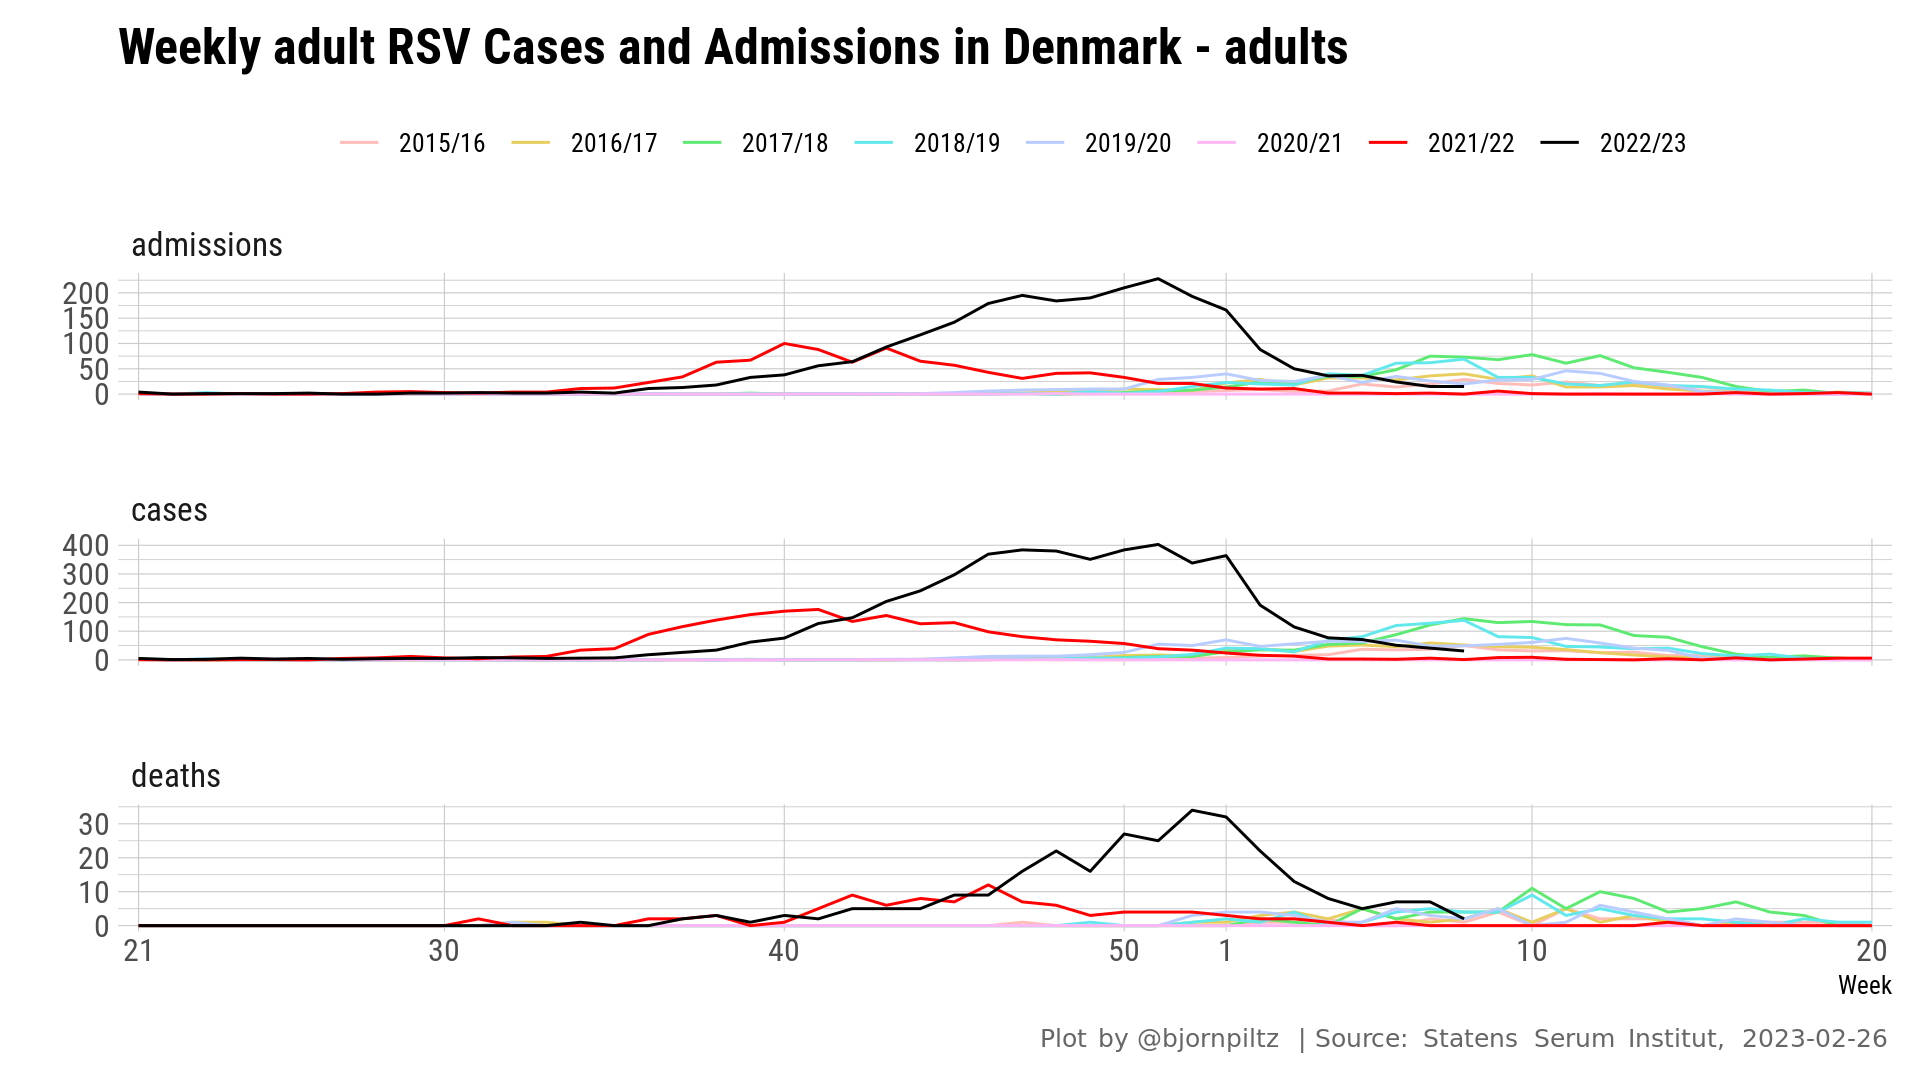

In [6]:
s = 1.2
options(repr.plot.width = s*8, repr.plot.height = s*4.5, repr.plot.res = 240/s)
s = 0.6
options(repr.plot.width = s*16, repr.plot.height = s*9, repr.plot.res = 120/s)

df%>%
  mutate(Week = factor(as.factor(Week), levels = append(seq(21, 52), seq(1, 20))))%>%
  filter(type %in% c("cases", "admissions", "deaths"))%>%
  filter(Week!=53)%>%
  group_by(Week, Season, type)%>%
  summarise(value = sum(value))%>%
  filter(!(Season == "2022/23" & as.integer(as.character(Week))>8 & as.integer(as.character(Week))<21))%>%
  ggplot(aes(x = Week, y = value, color = Season, group = interaction(type, Season))) +
  labs(title = "Weekly adult RSV Cases and Admissions in Denmark - adults",
       caption = caption, color = "", y = "") +
  scale_color_manual(values = line_colors) +
  scale_x_discrete(breaks = c("21", "30", "40", "50", "1", "10", "20")) +
  geom_line() +
  facet_wrap(~type, scale = "free_y", ncol = 1) +
  theme(legend.position = "top")+
  guides(color = guide_legend(nrow = 1)) +
  savePlot("adults_overview")

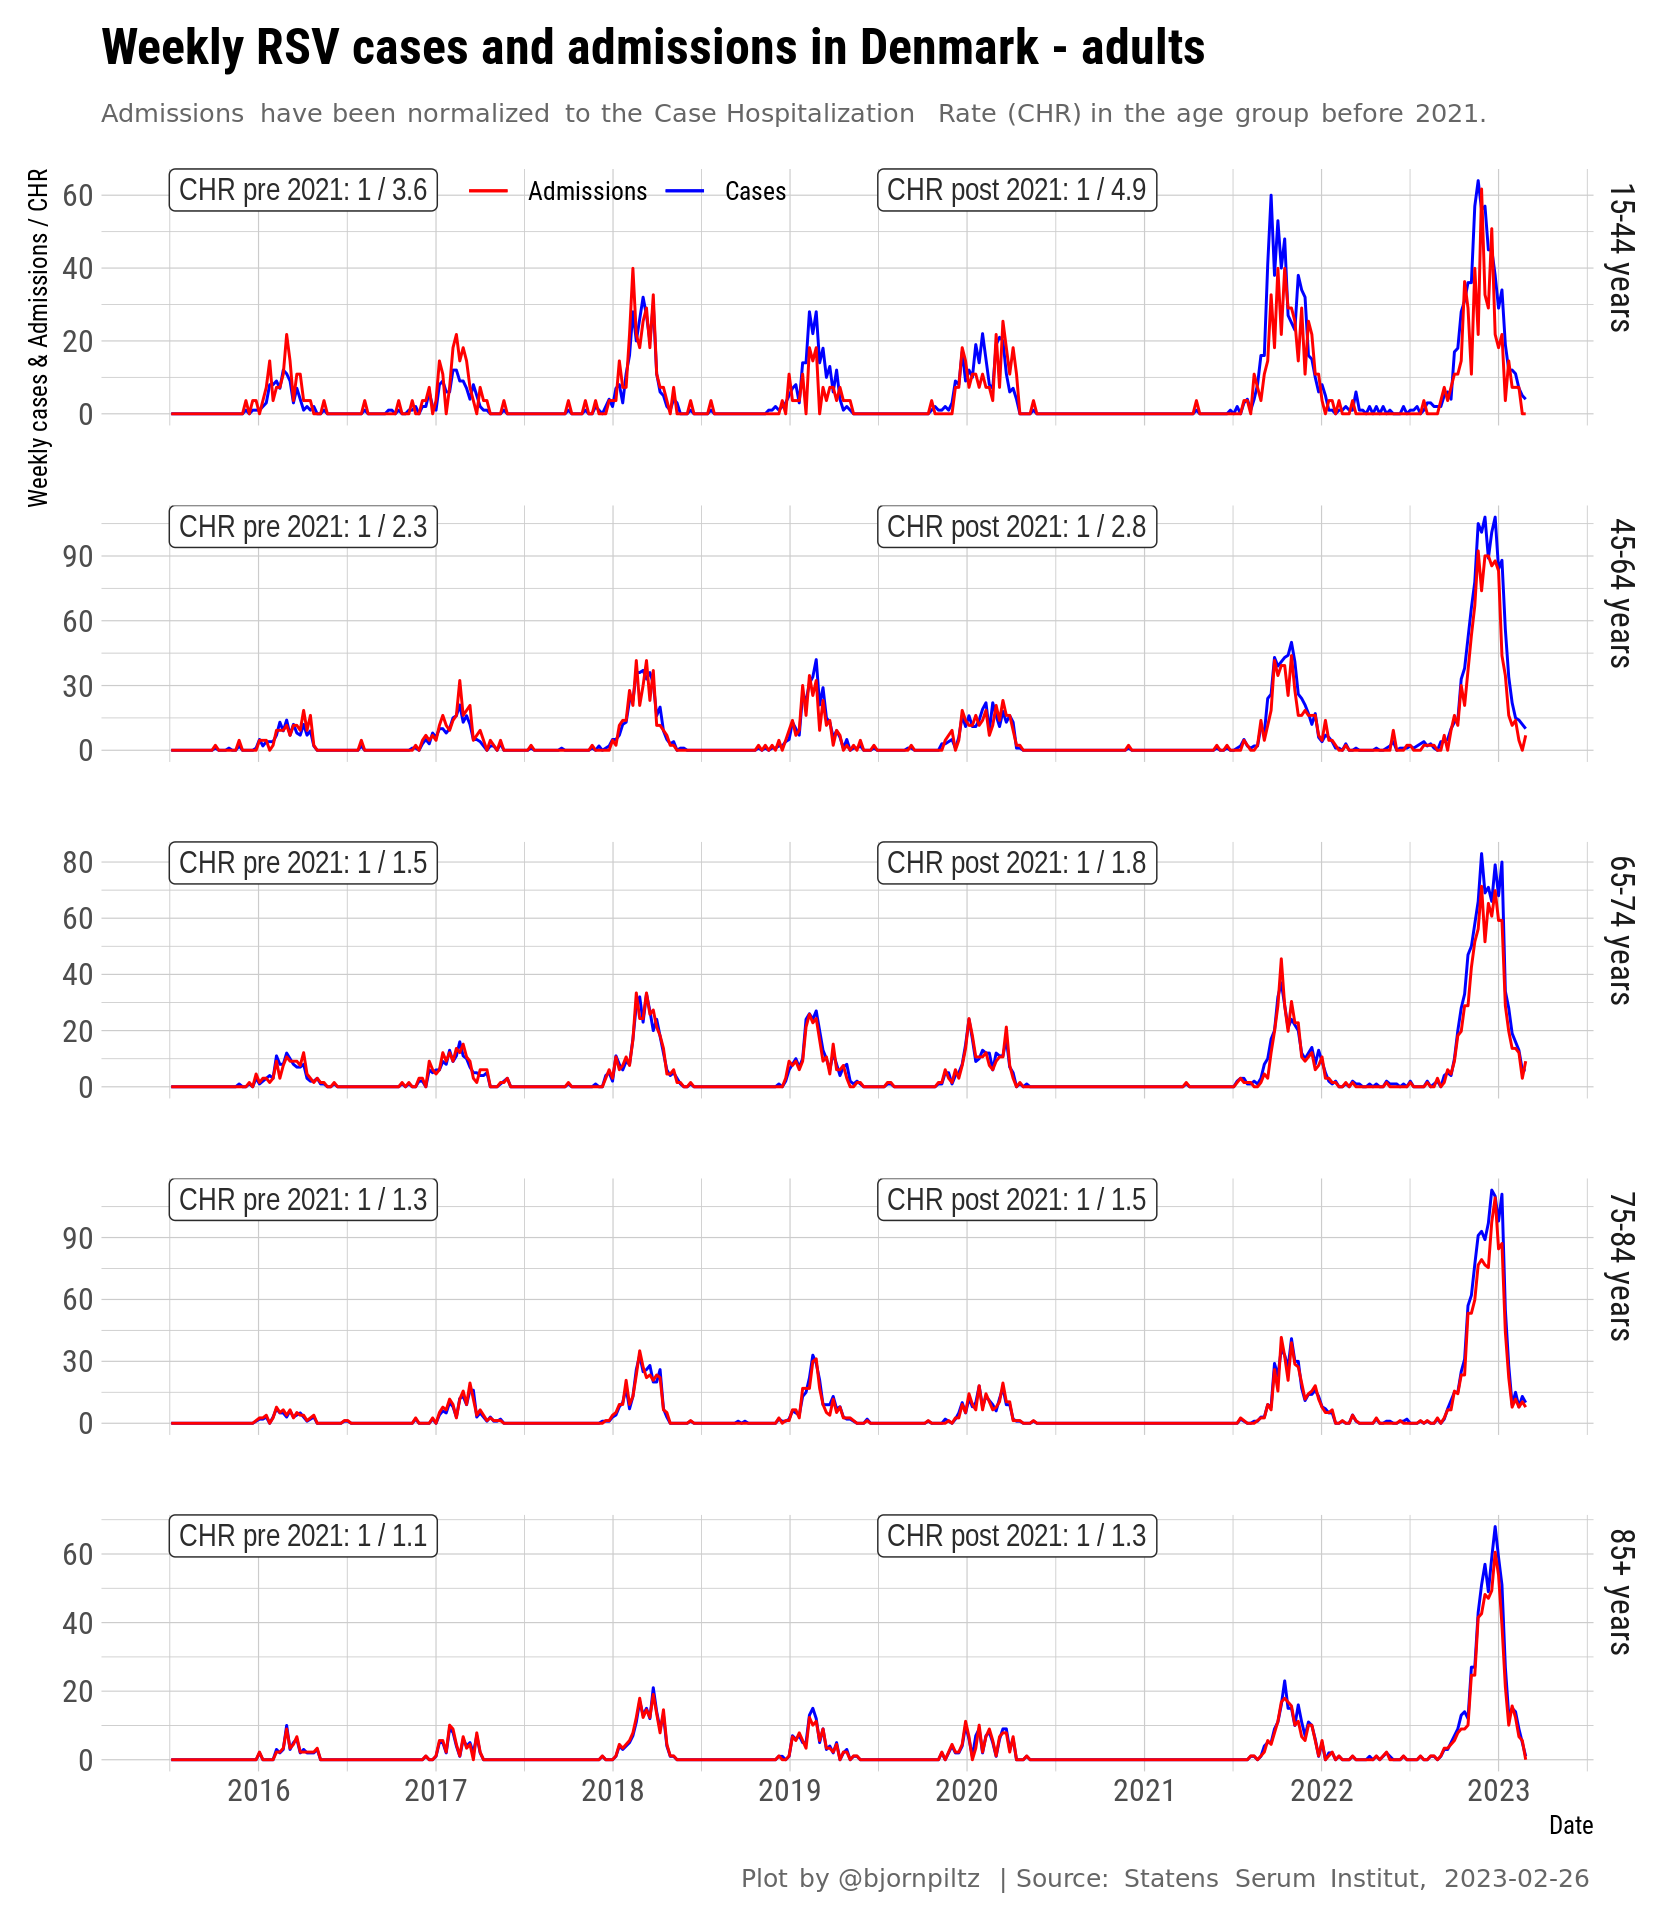

In [8]:
s = 0.6
options(repr.plot.width = s*14, repr.plot.height = s*16, repr.plot.res = 120/s)

df_ratio <-
  df%>%
  filter(Date>="2015-07-01" & Date<"2020-03-01")%>%
  spread(type, value)%>%
  group_by(`Age Group`)%>%
  summarise(cases = sum(cases),
            admissions = sum(admissions))%>%
  mutate(ratio = cases/admissions)%>%
  select(`Age Group`, ratio)

df_ratio_post <-
  df%>%
  filter(Date>="2020-03-01")%>%
  spread(type, value)%>%
  group_by(`Age Group`)%>%
  summarise(cases = sum(cases),
            admissions = sum(admissions, na.rm = T))%>%
  mutate(ratio = cases/admissions)%>%
  select(`Age Group`, ratio)

df%>%
  filter(Date>="2015-07-01" & Date<=last_date)%>%
  spread(type, value)%>%
  group_by(Date, `Age Group`)%>%
  summarise(cases = sum(cases),
            admissions = sum(admissions),
           .groups = "drop")%>%
  merge(df_ratio)%>%
  ggplot(aes(x = Date, y = cases)) +
  labs(title = "Weekly RSV cases and admissions in Denmark - adults",
       subtitle = "Admissions have been normalized to the Case Hospitalization Rate (CHR) in the age group before 2021.",
       caption = caption, color = "", y = "Weekly cases & Admissions / CHR") +
  geom_line(aes(x = Date, y = cases, color = "Cases")) +
  geom_line(aes(x = Date, y = admissions*ratio, color = "Admissions")) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  scale_color_manual(values = c("red", "blue")) +
  facet_grid(`Age Group`~., scale = "free_y") +
  guides(color=guide_legend(ncol=2))+
  theme(legend.position = c(0.35, 1),
        plot.subtitle = element_markdown(lineheight = 1.5, size = rel(0.8)))+ 
  geom_label(data = df_ratio, aes(x = as.Date("2015-07-01"), y = Inf, 
                                label = paste0("CHR pre 2021: 1 / ", format(ratio, digits = 2))),
          hjust = 0, vjust = 1, nudge_y = -30, size = 4)+
  geom_label(data = df_ratio_post, aes(x = as.Date("2019-07-01"), y = Inf, 
                                label = paste0("CHR post 2021: 1 / ", format(ratio, digits = 2))),
          hjust = 0, vjust = 1, nudge_y = -30, size = 4) +
  savePlot("adults_case_admissions")

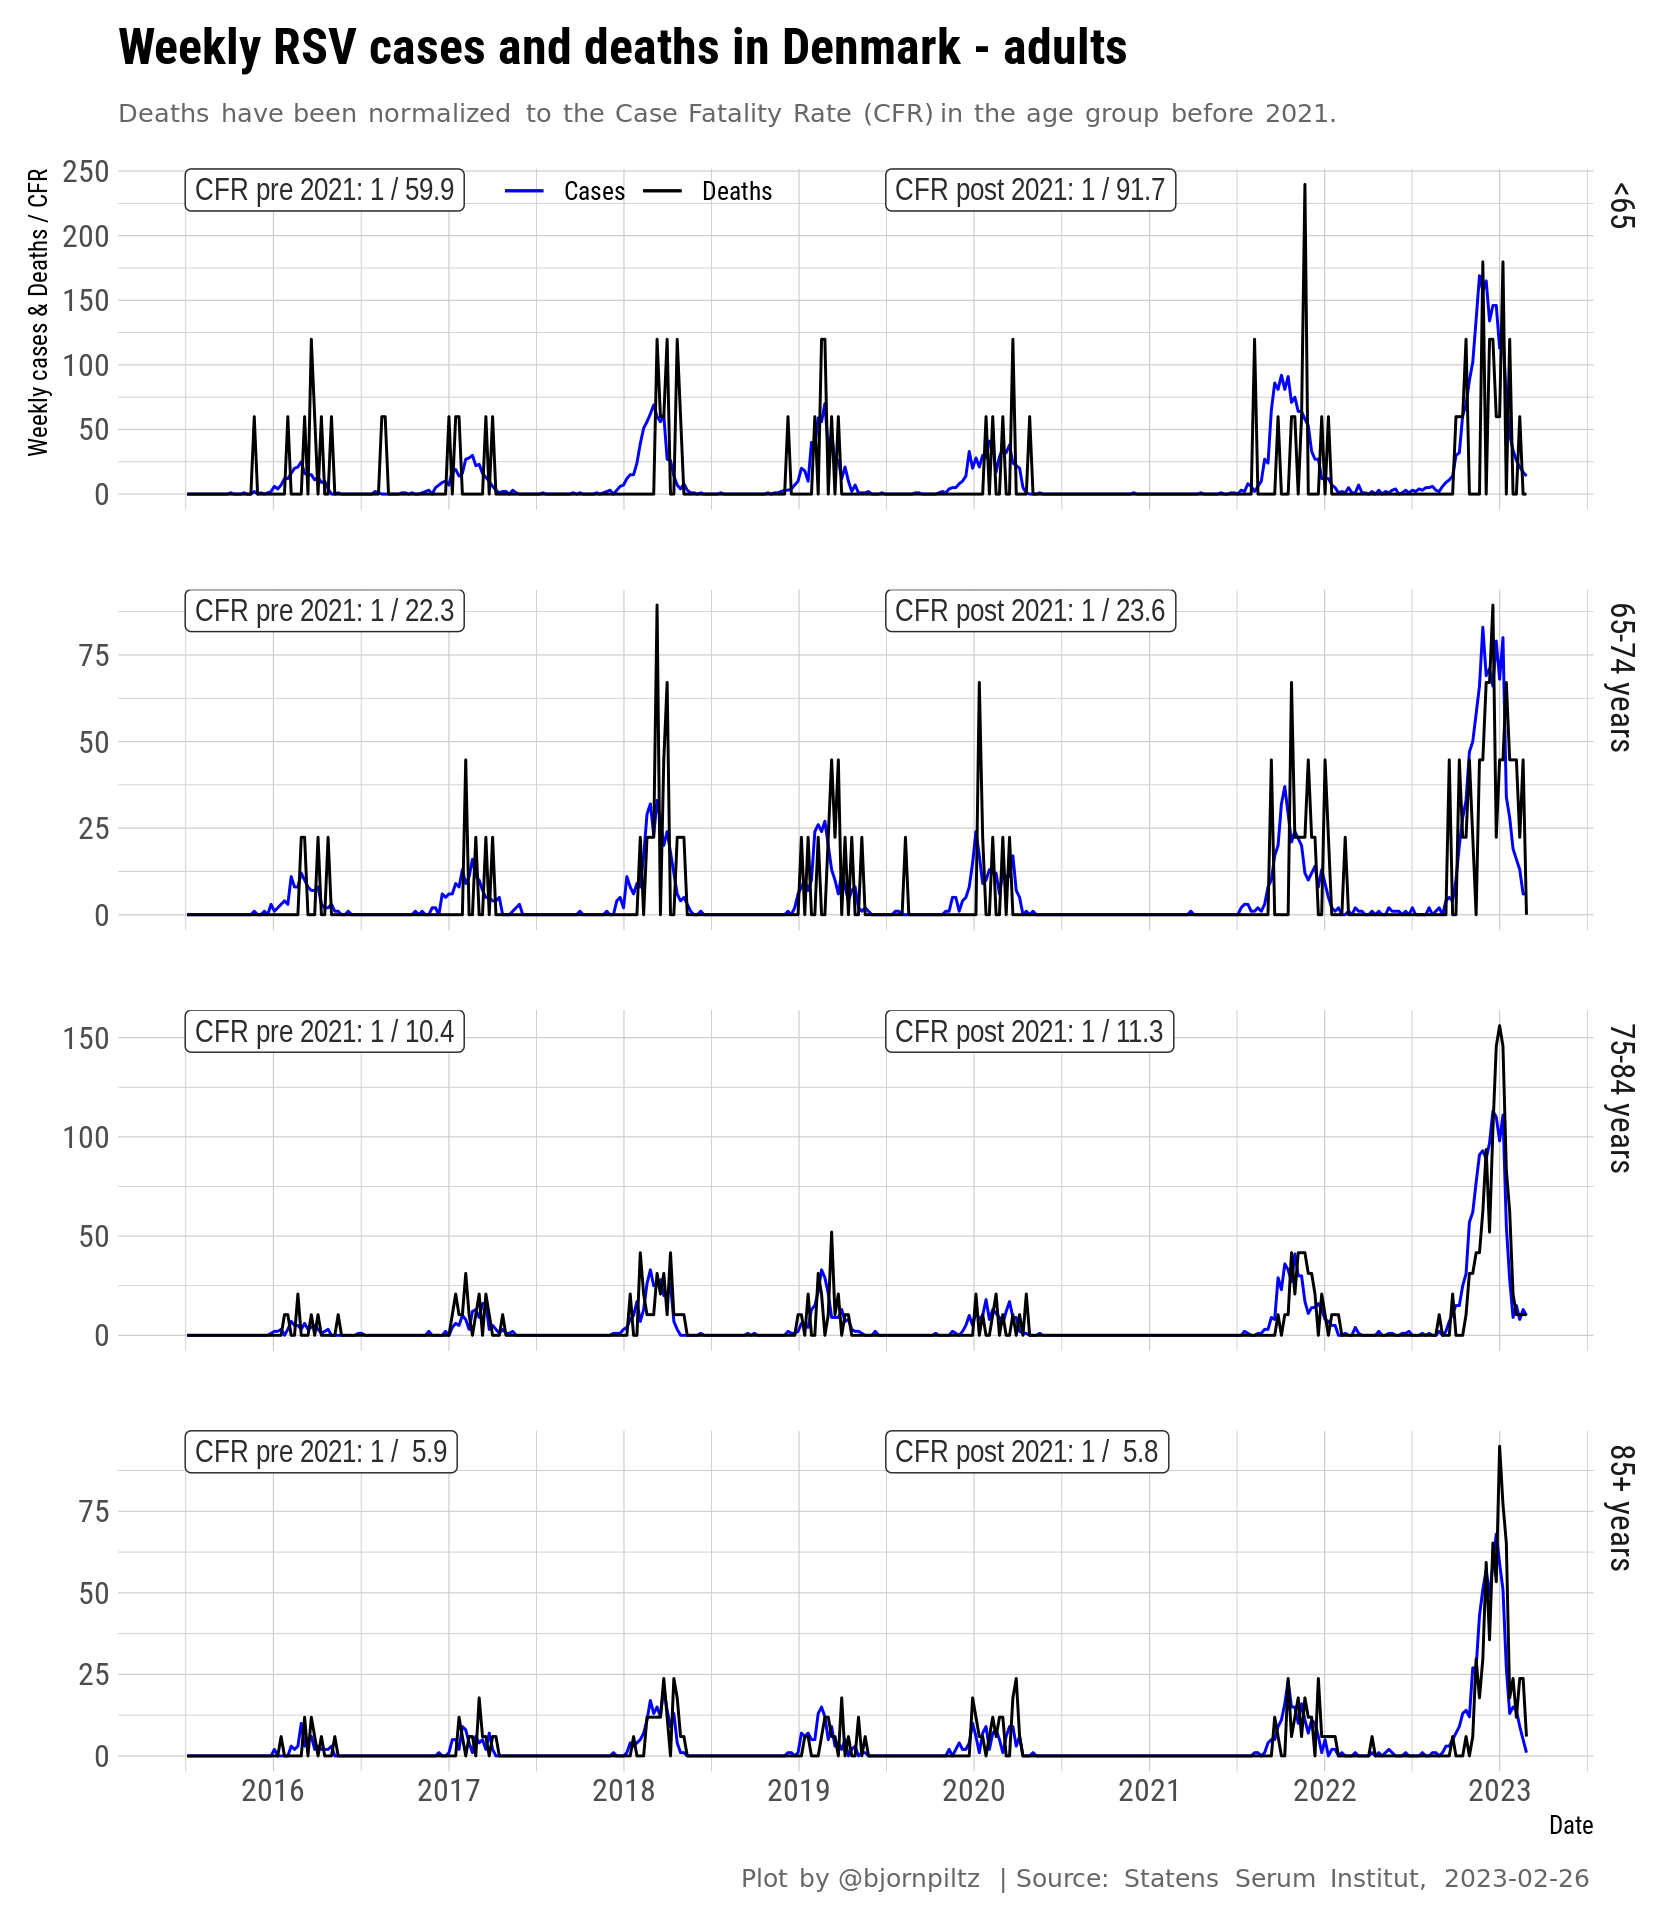

In [26]:
s = 0.6
options(repr.plot.width = s*14, repr.plot.height = s*16, repr.plot.res = 120/s)

df_tmp <- df%>%
  spread(type, value)%>%
  mutate(`Age Group` = as.character(`Age Group`))%>%
  mutate(`Age Group` = ifelse(parse_number(as.character(`Age Group`))<65, "<65", `Age Group`))

df_ratio <-
  df_tmp%>%
  filter(Date>="2015-07-01" & Date<"2020-03-01")%>%
  group_by(`Age Group`)%>%
  summarise(cases = sum(cases),
            deaths = sum(deaths))%>%
  mutate(ratio = cases/deaths)%>%
  select(`Age Group`, ratio)

df_ratio_post <-
  df_tmp%>%
  filter(Date>="2020-03-01")%>%
  group_by(`Age Group`)%>%
  summarise(cases = sum(cases),
            deaths = sum(deaths, na.rm = T))%>%
  mutate(ratio = cases/deaths)%>%
  select(`Age Group`, ratio)

df_tmp%>%
  filter(Date>="2015-07-01" & Date<=last_date)%>%
  group_by(Date, `Age Group`)%>%
  summarise(cases = sum(cases),
            deaths = sum(deaths),
           .groups = "drop")%>%
  merge(df_ratio)%>%
  ggplot(aes(x = Date, y = cases)) +
  labs(title = "Weekly RSV cases and deaths in Denmark - adults",
       subtitle = "Deaths have been normalized to the Case Fatality Rate (CFR) in the age group before 2021.",
       caption = caption, color = "", y = "Weekly cases & Deaths / CFR") +
  geom_line(aes(x = Date, y = cases, color = "Cases")) +
  geom_line(aes(x = Date, y = deaths*ratio, color = "Deaths")) +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
  scale_color_manual(values = c("blue", "black")) +
  facet_grid(`Age Group`~., scale = "free_y") +
  guides(color=guide_legend(ncol=2))+
  theme(legend.position = c(0.35, 1),
        plot.subtitle = element_markdown(lineheight = 1.5, size = rel(0.8)))+ 
  geom_label(data = df_ratio, aes(x = as.Date("2015-07-01"), y = Inf, 
                                label = paste0("CFR pre 2021: 1 / ", format(ratio, digits = 2))),
          hjust = 0, vjust = 1, nudge_y = -30, size = 4)+
  geom_label(data = df_ratio_post, aes(x = as.Date("2019-07-01"), y = Inf, 
                                label = paste0("CFR post 2021: 1 / ", format(ratio, digits = 2))),
          hjust = 0, vjust = 1, nudge_y = -30, size = 4) +
  savePlot("adults_case_deaths")

`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Date', 'Season'. You can override using
the `.groups` argument.
Warning message:
“Removed 65 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 65 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 65 rows containing missing values (`geom_line()`).”


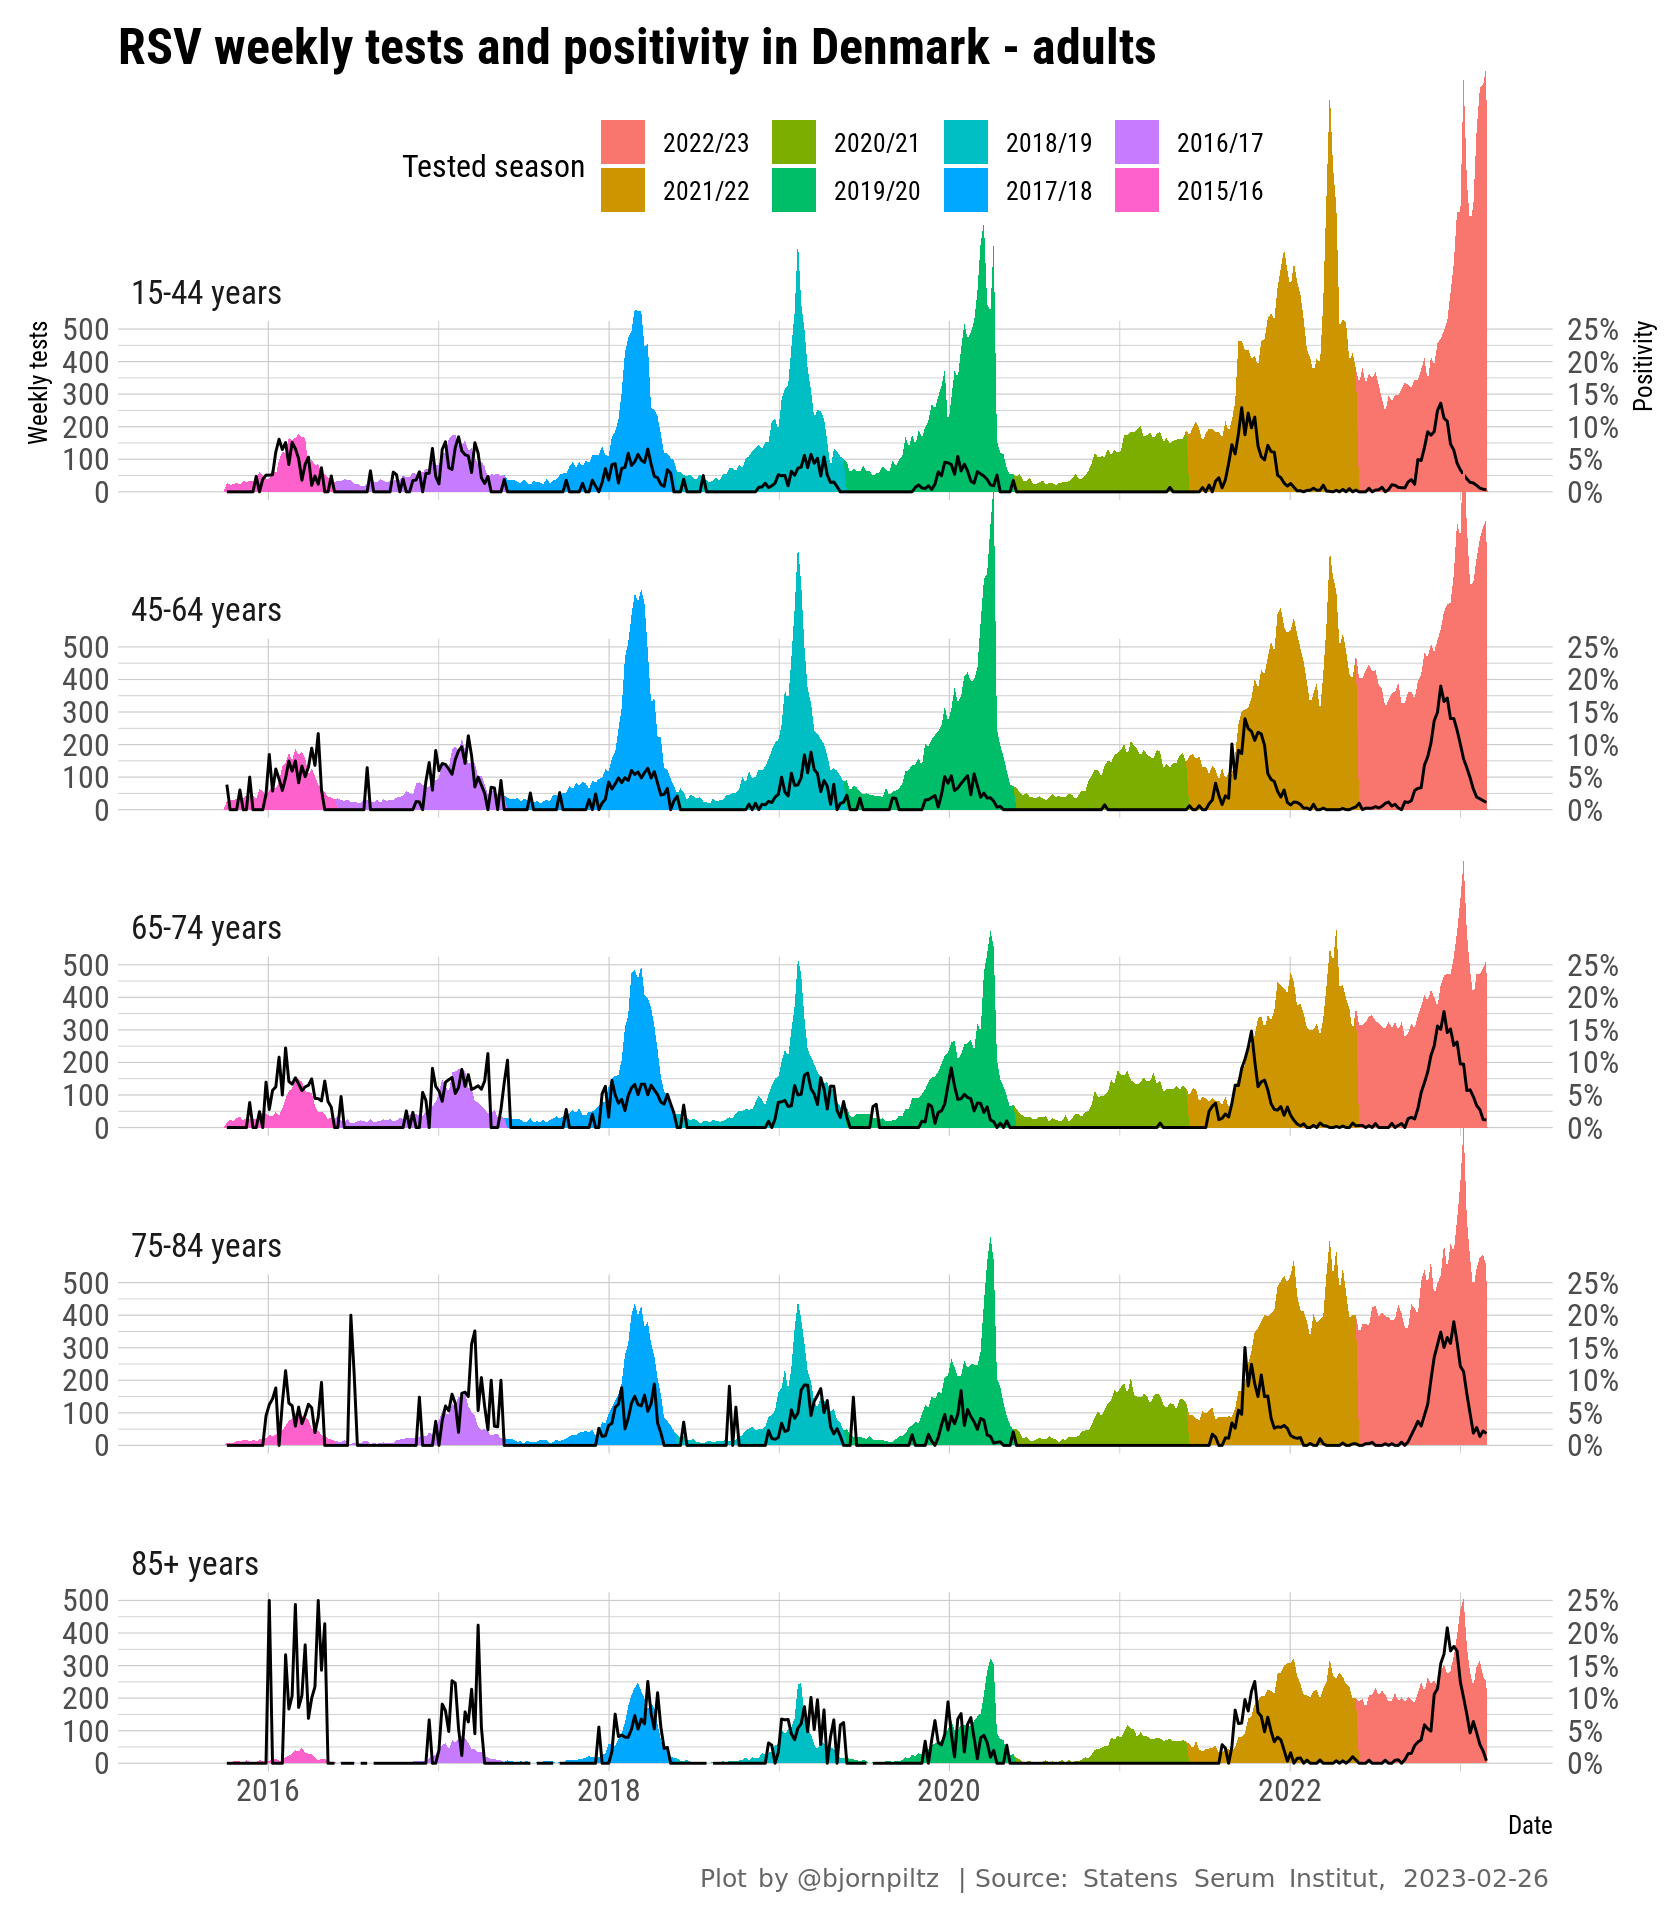

In [27]:
s = 0.6
options(repr.plot.width = s*14, repr.plot.height = s*16, repr.plot.res = 120/s)

df_pos_age <-
  df%>%
  filter(Date>="2015-07-01" & Date<=last_date)%>%
  spread(type, value)%>%
  group_by(Date,  `Age Group`)%>%
  summarise(cases  = sum(cases, na.rm = T),
            tested  = sum(tested, na.rm = T))%>%
  mutate(positivity = cases/tested*100)

df%>%
  spread(type, value)%>%
  filter(Date>="2015-07-01" & Date<=last_date)%>%
  group_by(Date, Season, `Age Group`)%>%
  summarise(tested = sum(tested, na.rm = T),
            cases = sum(cases, na.rm = T)) %>%
  ggplot(aes(x = Date, y = tested)) +
  labs(title = "RSV weekly tests and positivity in Denmark - adults", 
       fill = "Tested season", y = "Weekly tests", caption = caption) +
  geom_area(aes(fill = fct_rev(Season))) +
  geom_line(data = df_pos_age, aes(y = cases/tested*2000, group = `Age Group`), color = "black") +
  scale_y_continuous(sec.axis = sec_axis(~ . /2000, name = "Positivity",  labels = scales::percent)) +
  coord_cartesian(ylim = c(0, 500), clip = "off") +
  facet_wrap(~`Age Group`, ncol = 1) +
  theme(legend.position = "top") +
  savePlot("adults_test_positivity")

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”


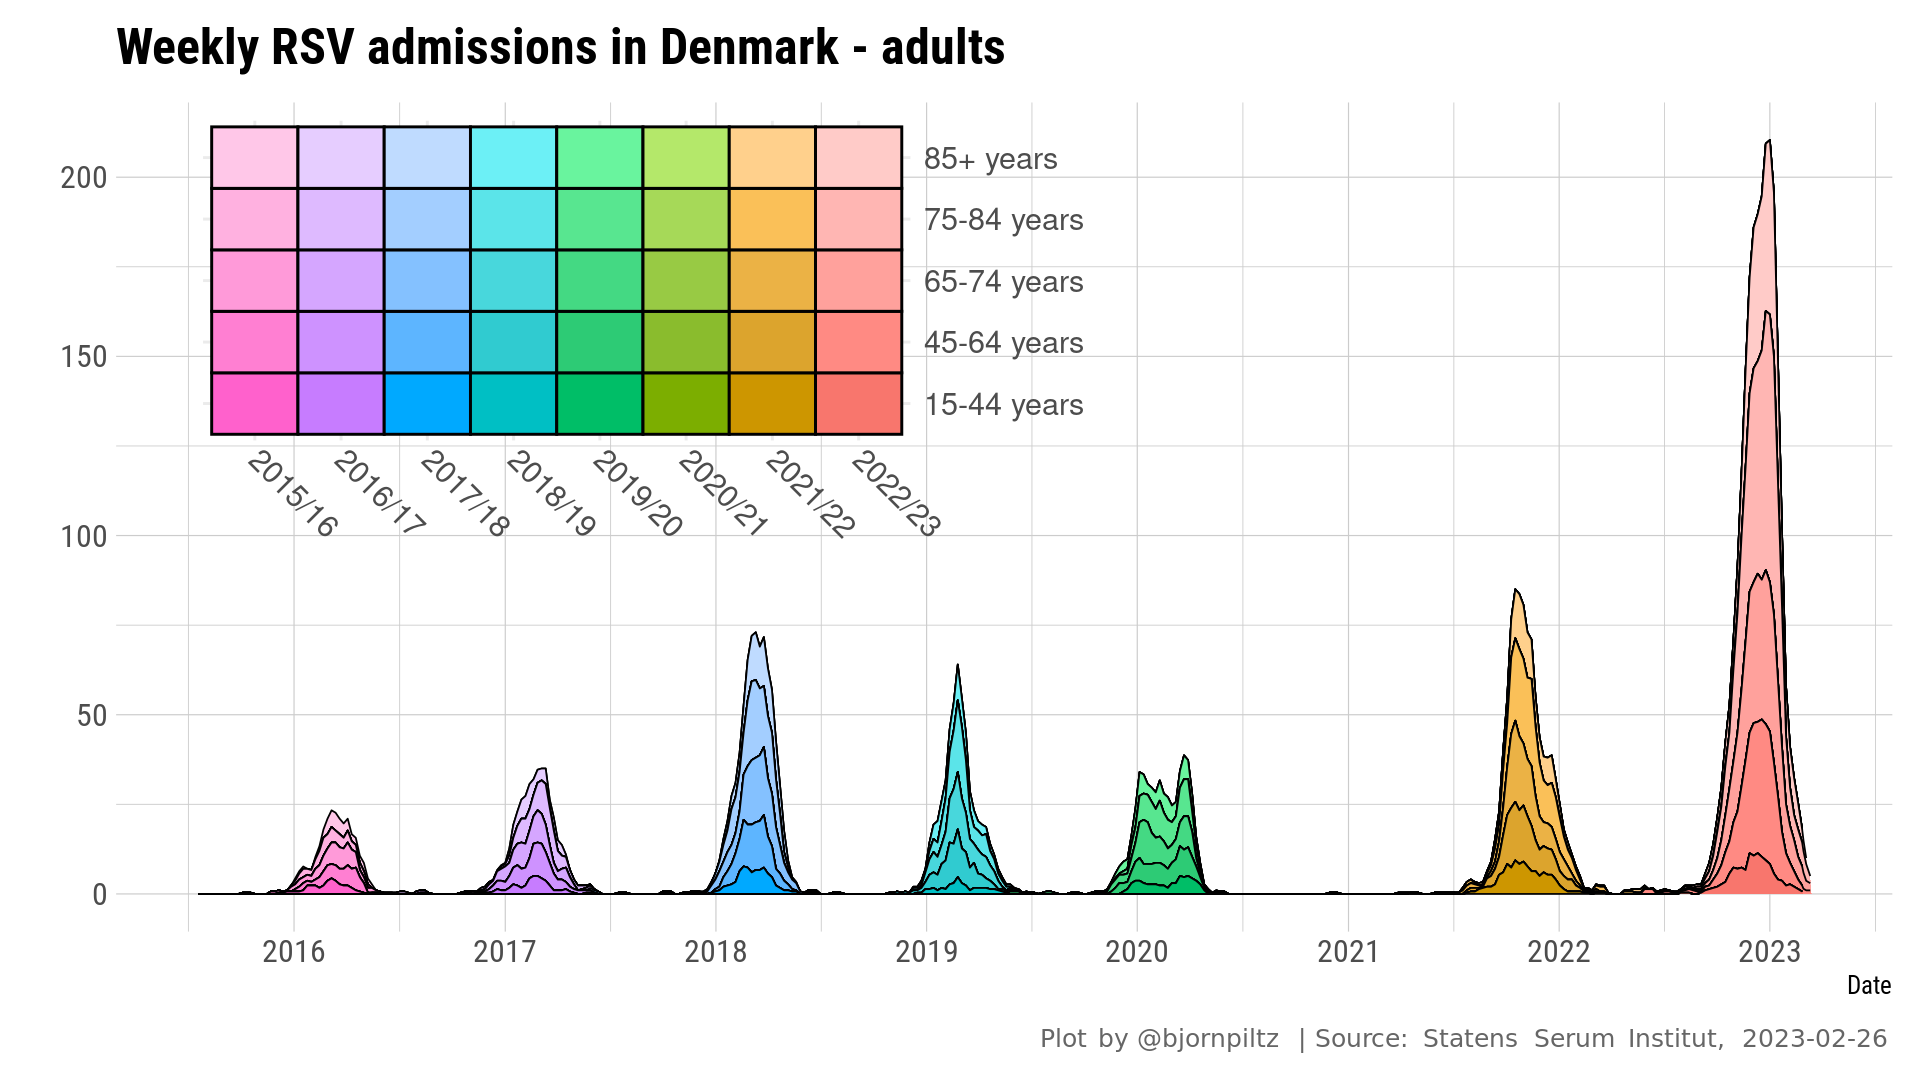

In [28]:
s = 0.6
options(repr.plot.width = s*16, repr.plot.height = s*9, repr.plot.res = 120/s)

plot_rsv <- function(type_, scale=1){
    
    df%>%
      filter(type == type_)%>%
      filter(Date>="2015-07-01" )%>%
      group_by(Season, Date, `Age Group`)%>%
      summarise(value = sum(value), .groups = "drop")%>%
      group_by(Season, `Age Group`)%>%
      mutate(value = zoo::rollmean(value, 3, na.pad = T, align = "right")) %>%
      filter(Date <= last_date | value != 0) %>%
      ggplot(aes(x = Date, y = value, group = interaction(Season, fct_rev(`Age Group`)))) +
      labs(title = paste("Weekly RSV", type_, "in Denmark - adults"),
                        caption = caption, y="") +
      geom_area(aes(fill = interaction(`Age Group`, fct_rev(Season))), color = "black", size = 0.3) +
      scale_fill_manual(values = fill_colors(n_age_groups)) +
      scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
      theme(legend.position = "none") +
      annotation_custom(ggplotGrob(plot_inset(n_age_groups) +
                                     theme(axis.text.x = element_text(size = 11),
                                           axis.text.y = element_text(size = 11))), 
                        xmin = as.Date("2015-07-01"), 
                        xmax = as.Date("2020-01-01"), 
                        ymin = 80*scale, 
                        ymax = 220*scale) +
    savePlot(paste0("adults_", type_, "_by_week"))
}
plot_rsv("admissions")

Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”


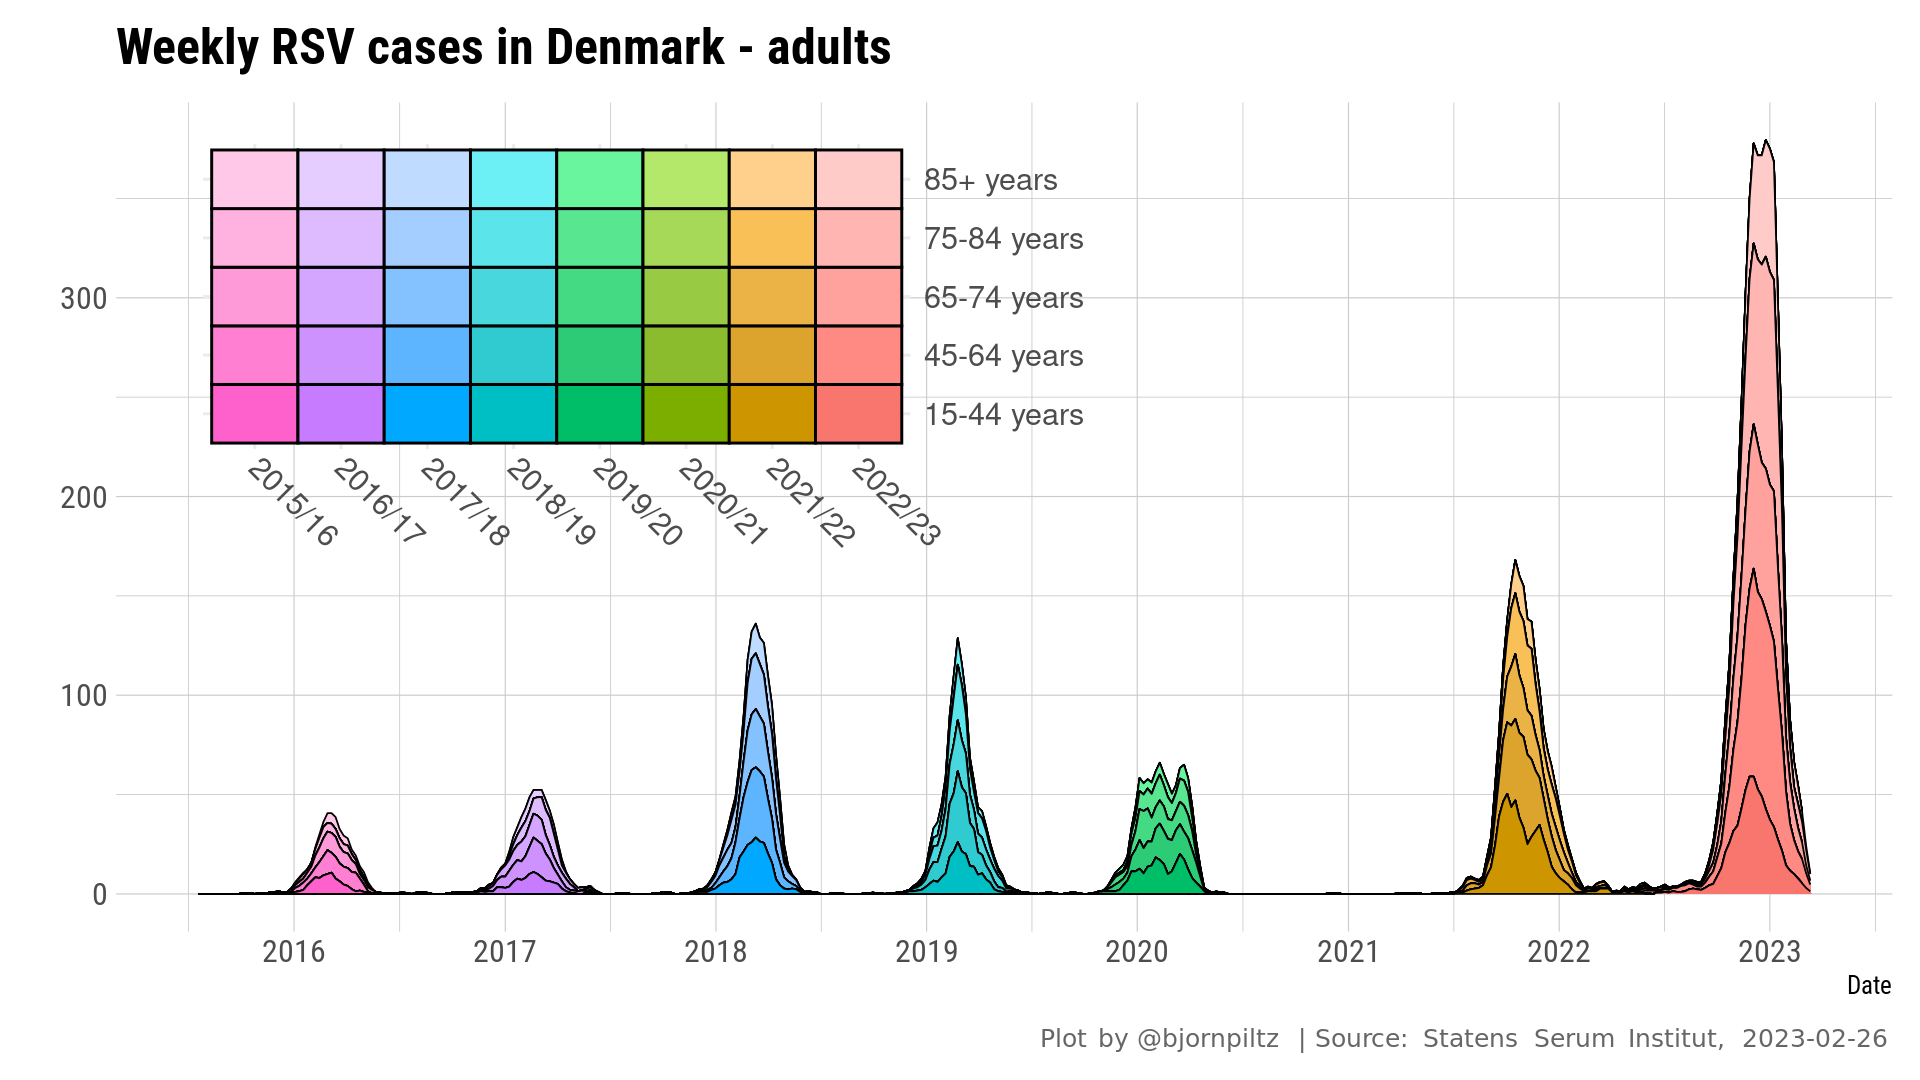

In [29]:
plot_rsv("cases", 1.75)

Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 80 rows containing non-finite values (`stat_align()`).”


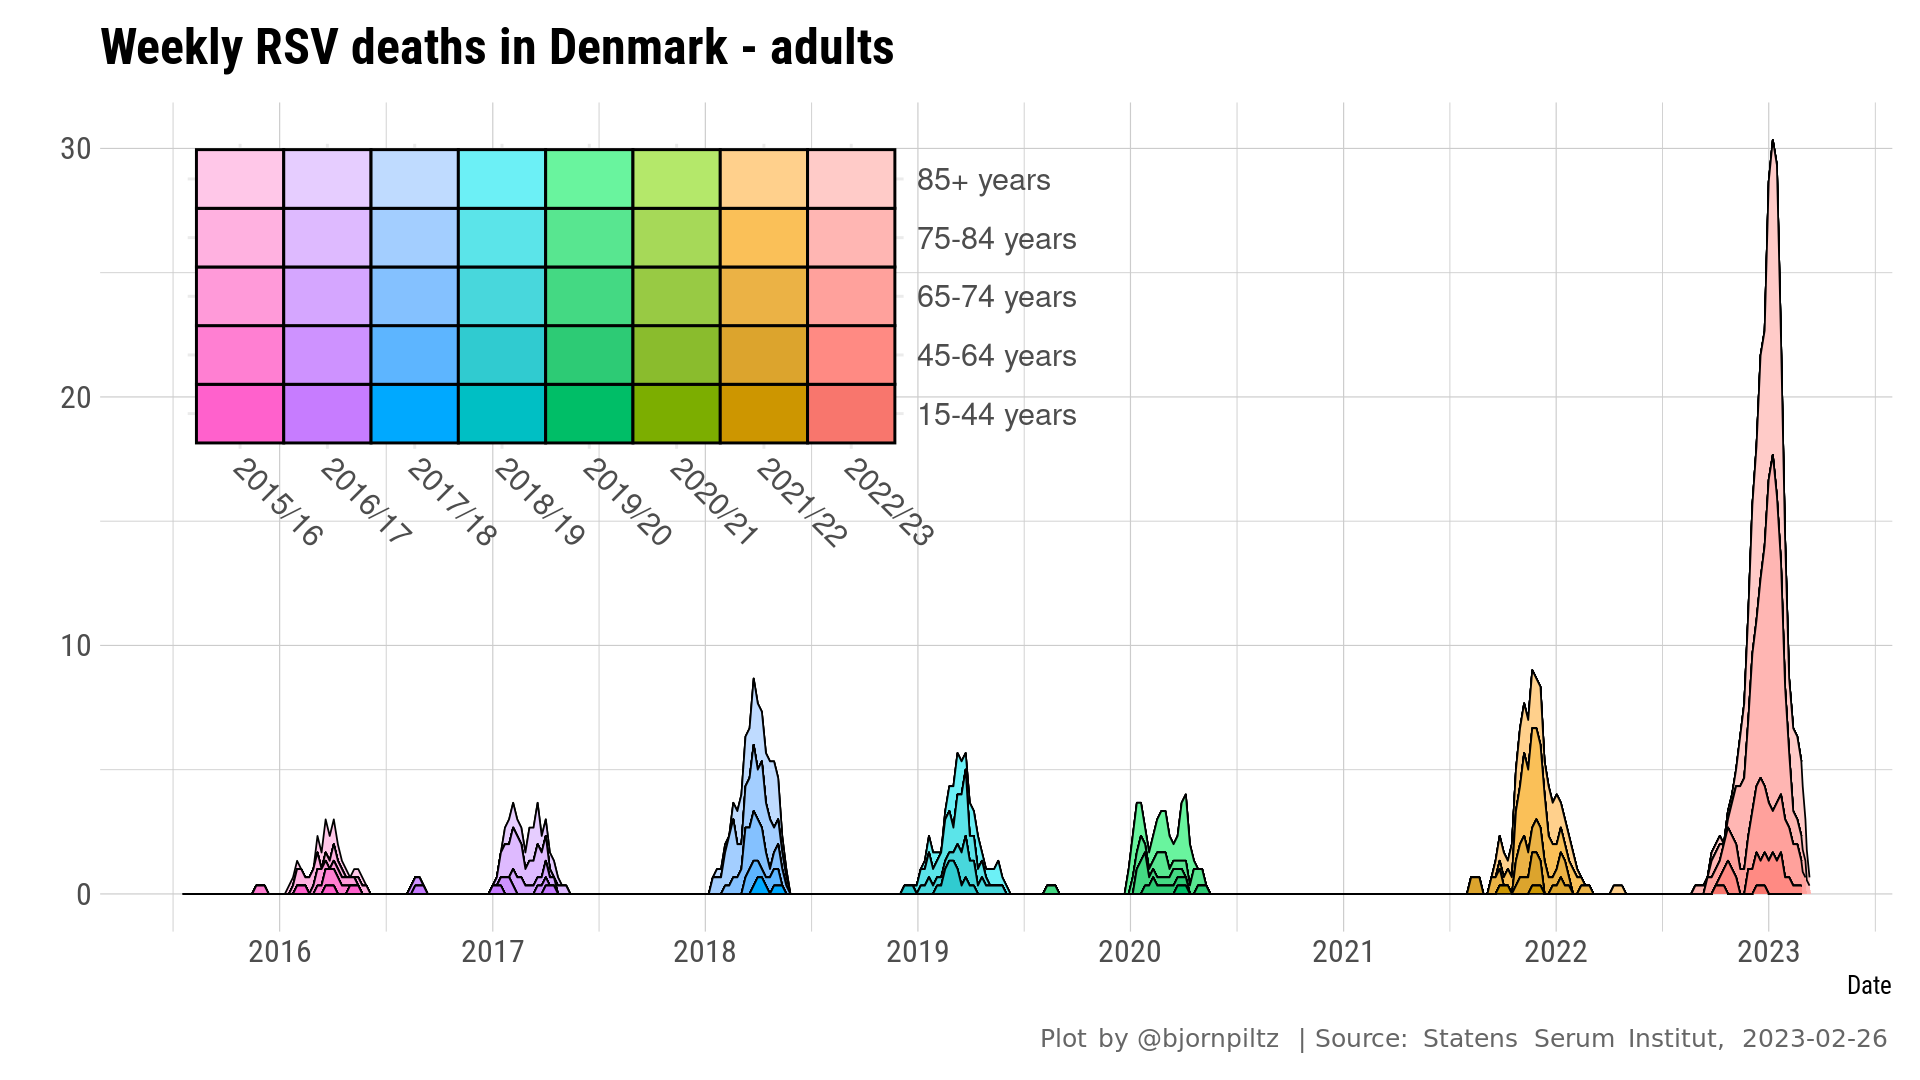

In [30]:
plot_rsv("deaths", 0.14)

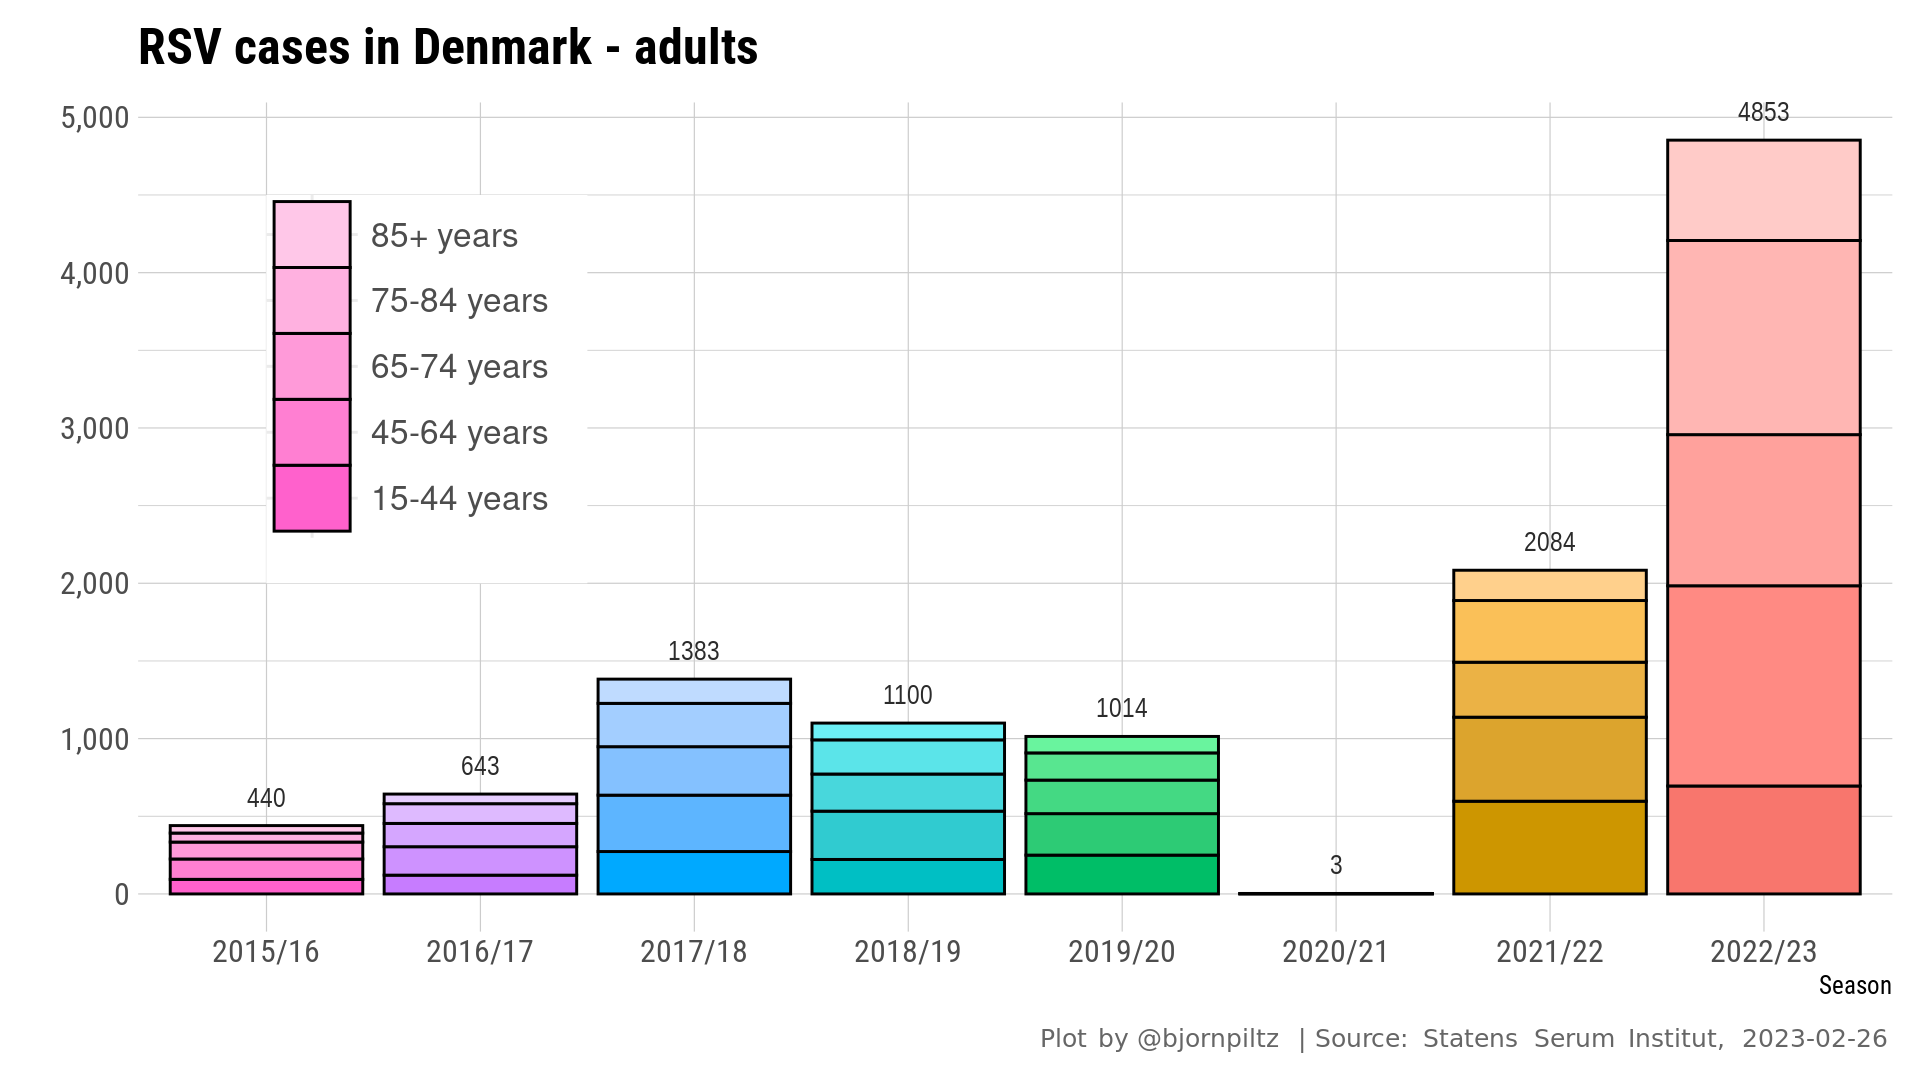

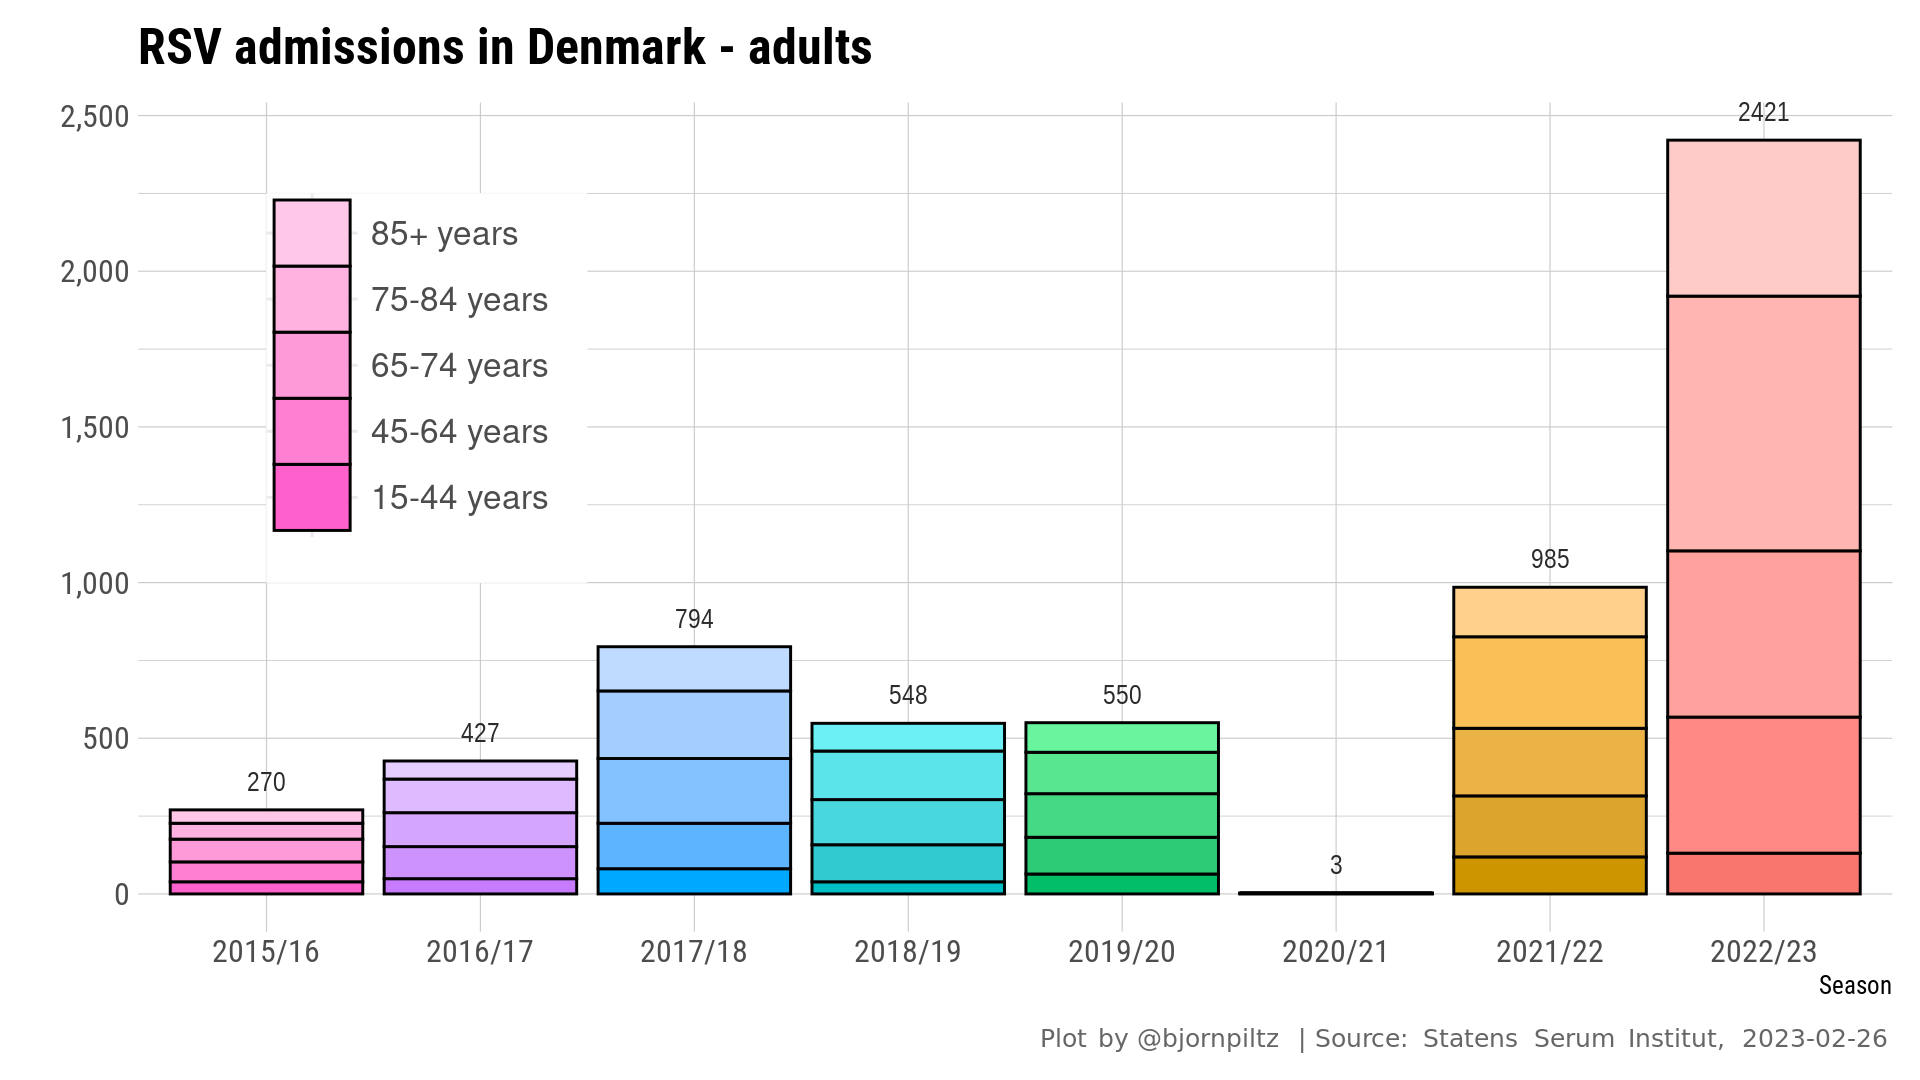

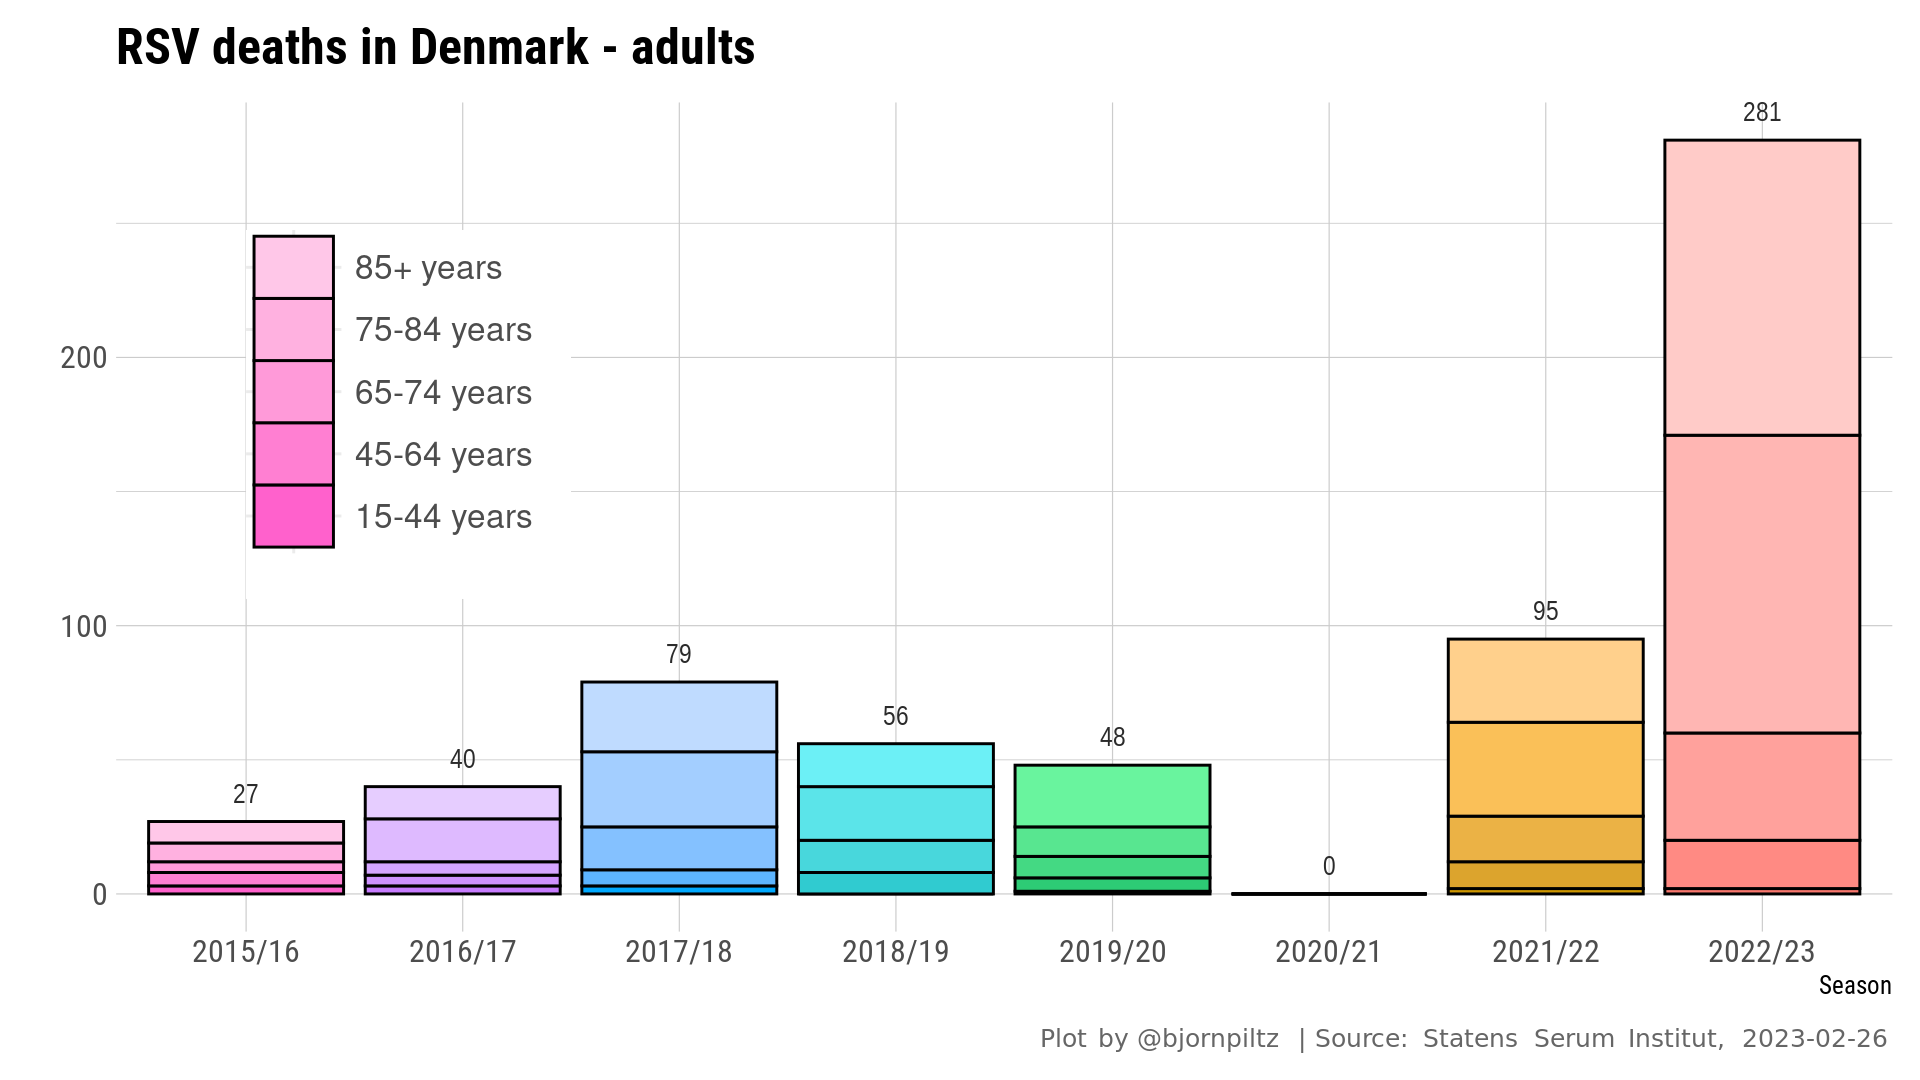

In [31]:
s = 0.6
options(repr.plot.width = s*16, repr.plot.height = s*9, repr.plot.res = 120/s)

plot_rsv_by_season <- function(type_, scale = 1){
    
    inset <- plot_inset_small(n_age_groups) +
          theme(axis.text.y = element_text(size = 12))+
          theme(plot.background = element_rect(fill = "white", color = "white"),
                panel.background = element_blank(),
                plot.margin = margin(0, 0, 0, 0))
    dummy <- 
      df%>%
      filter(type == type_)%>%
      group_by(Season, type)%>%
      summarise(value = sum(value, na.rm = T), .groups = "drop")
    
    df%>%
      group_by(Season, `Age Group`, type)%>%
      summarise(value = sum(value, na.rm = T), .groups = "drop")%>%
      filter(type == type_)%>%
      ggplot(aes(x = Season, y = value)) +
      labs(title = paste("RSV", type_, "in Denmark - adults"),
           caption = caption, x = "Season", y = "", fill = "") +
      geom_col(aes(fill = interaction(fct_rev(`Age Group`), fct_rev(Season))), color = "black") +
      scale_fill_manual(values = fill_colors_inverse(n_age_groups)) +
      scale_y_continuous(labels = scales::comma) +
      geom_text(data = dummy, aes(label=value), vjust=-1) +
      theme(legend.position = "none") +
           annotation_custom(ggplotGrob(inset), 
                             xmin = 1, 
                             xmax = 2.5, 
                             ymin = 2000*scale, ymax = 4500*scale) +
      savePlot(paste0("adults_", type_, "_by_season"))
}
plot_rsv_by_season("cases")
plot_rsv_by_season("admissions", 0.50)
plot_rsv_by_season("deaths", 0.055)